# Chronic Kidney Disease Classification

Training the Neural Network and Additional Preprocessing Steps


Author: cayscays

Date: 2023

Website: https://github.com/cayscays/

---

In this notebook, I train the [neural network](https://github.com/cayscays/neural-network-from-scratch/tree/main) on the Chronic Kidney Disease dataset. Prior to loading the data into this notebook, I conducted preprocessing steps including anomaly detection, handling missing values, replacement of missing values, and data discretization. Within this notebook, I transform binary and continuous features to prepare the dataset for training.

---

**Important Notice:**

For explanations regarding the content of this notebook, including  dataset preprocessing and transformation for neural network input, model architecture and training process, as well as results, please refer to the '_Project 1: Chronic Kidney Disease Classification_' section in the main README file. All explanations regarding this code can be found there.


[Link to the README](https://github.com/cayscays/neural-network-from-scratch/blob/main/README.md#project-1-chronic-kidney-disease-classification)

# Data Preprocessing for Neural Network Input

The data labels:

0: not ckd

1: ckd

In [ ]:
import pandas as pd
data_file = pd.read_csv('/content/preprocessed_data.csv')
data_file.columns
print("There are " + str(len(data_file)) + " entries in the dataset")

There are 389 entries in the dataset


In [ ]:
raw_data = data_file.iloc[:, :].values
print(raw_data.shape)

(389, 23)


In [1]:
import re

def entry_data_to_int(raw_entry):
  entry = []
  features = []
  classification = []
  for i in range(0,len(raw_entry) - 1):
    match raw_entry[i]:
      case 'normal':
        features.append(0)
      case 'abnormal':
        features.append(1)
      case 'no':
        features.append(0)
      case 'yes':
        features.append(1)
      case 'notpresent':
        features.append(0)
      case 'present':
        features.append(1)
      case 'good':
        features.append(0)
      case 'bad':
        features.append(1)
      case 'poor':
        features.append(1)
      case _:
        # save the first number:
        val = float(re.search('[0-9,.]+', raw_entry[i]).group())
        val = val ** (-1)
        features.append(val)
  match raw_entry[-1]:
    case 'notckd':
      classification.append(0)
    case 'ckd':
      classification.append(1)
  entry.append(features)
  entry.append(classification)
  return entry

In [ ]:
data = []

for i in range (0, len(raw_data)):
  data.append(entry_data_to_int(raw_data[i]))
len(data[0][0])

22

# The neural network

In [ ]:
import random

The neural network:

In [ ]:
"""
Author:       cayscays
Date:         December 2021
Version:      1
Description:  A neural network implemented from scratch
"""

import random
import numpy as np


class NeuralNetwork:
    """
    A fully connected neural network
    """

    def __init__(self, input_size, hidden_layers_sizes, output_size,
                 learning_rate, amount_of_epochs, batch_size, data, seed):
        """
            Initializes the neural network.

            Args:
                input_size (list): The number of neurons in the input layer.
                hidden_layers_sizes (list): The number of neurons in the hidden layers.
                output_size (list): The number of neurons in the output layer.
                learning_rate (float): The learning rate for the network.
                amount_of_epochs (int): The number of epochs to train the network for.
                batch_size (int): The size of the batch (currently supports batch size of 1).
                data (list): The data for training and testing.
                seed (int): The seed for random initialization.
        """
        random.seed(seed)
        self.all_layers_sizes = input_size + hidden_layers_sizes + output_size
        self.learning_rate = learning_rate
        self.amount_of_epochs = amount_of_epochs
        self.batch_size = batch_size  # For future batch features. currently supports batch size of 1.

        self.errors = {'training': [], 'test': []}
        self.accuracy = {'training': [], 'test': []}
        self.epochs = []

        # Initiates random weights
        self.weights = []
        for i in range(len(self.all_layers_sizes) - 1):
            self.weights.append(np.random.rand(self.all_layers_sizes[i + 1], self.all_layers_sizes[i]))

        self.values = []
        for layer in self.all_layers_sizes:
            self.values.append(np.zeros(layer))

        self.delta = []
        for i in range(1, len(self.values)):
            self.delta.append(np.zeros(self.values[i].shape))

        # divide the data to test and training:
        random.shuffle(data)
        n = int(len(data) / 2)
        self.training_data = data[n:]
        self.test_data = data[:n]

    def sigmoid(self, vals):
        """
        Calculates the sigmoid function for the given values.

        Args:
            vals (numpy.array): Input values.

        Returns:
            numpy.array: Result of applying the sigmoid function to the input values.
        """
        return 1 / (np.exp(-vals) + 1.0)

    def get_label_id(self, output):
        """
        Determines the label id based on the output value.

        Args:
            output (numpy.array): Output value.

        Returns:
            int: Label ID.
        """
        if output[0] > 0.5:
            return 1
        else:
            return 0

    def forward_pass_single_input(self, single_input):
        """
        Performs a forward pass for a single input through the network.

        This method updates all neuron's values.
        Immediately after the input layer there is no activation function.


        Args:
            single_input (list): Input data.

        Returns:
            int: Predicted label id.
        """
        self.values[0] = np.array(single_input)
        # forward pass
        for i in range(1, len(self.all_layers_sizes)):
            self.values[i] = self.sigmoid(self.weights[i - 1] @ self.values[i - 1])
        return self.get_label_id(self.values[-1])

    def backpropagation(self, correct_label):
        """
        Updates the weights of the network using the backpropagation algorithm.

        Args:
            correct_label (numpy.array): The correct label for the current input.
        """
        output = self.values[len(self.values) - 1]
        self.delta[len(self.delta) - 1] = (correct_label - output) * output * (1 - output)

        for l in range(len(self.delta) - 2, -1, -1):
            for i in range(len(self.delta[l])):
                temp = 0
                for j in range(len(self.delta[l + 1])):
                    temp += (self.weights[l + 1][j][i] * self.delta[l + 1][j])
                self.delta[l][i] = self.values[l + 1][i] * (1 - self.values[l + 1][i]) * temp

        # update the weights
        for j in range(len(self.weights)):
            for i in range(len(self.weights[j])):
                # one line at a time:
                self.weights[j][i] += self.learning_rate * self.values[j] * self.delta[j][i]

    def calculate_single_run_error(self, target, output):
        """
        Calculates the error for a single run.

        Args:
            target (numpy.array): Target values.
            output (numpy.array): Output values.

        Returns:
            float: Error value.
        """
        error = 0
        for i in range(len(output)):
            error += (target[i] - output[i]) ** 2
        return error

    def run_epoch(self):
        """
        Runs an epoch of training on all the data.
        Updates error, accuracy, and weights.
        """
        training_error = 0
        test_error = 0
        training_accuracy = 0
        test_accuracy = 0
        for i in range(len(self.training_data)):
            # 1 for correct, 0 for incorrect
            training_accuracy += 1 + self.forward_pass_single_input(self.training_data[i][0]) - \
                                 self.training_data[i][1][0]

            self.backpropagation(self.training_data[i][1])
            training_error += self.calculate_single_run_error(self.training_data[i][1], self.values[-1])

            # 1 for correct, 0 for incorrect
            test_accuracy += 1 + self.forward_pass_single_input(self.test_data[i][0]) - self.test_data[i][1][0]

            test_error += self.calculate_single_run_error(self.test_data[i][1], self.values[-1])

        test_error /= len(self.test_data)
        training_error /= len(self.training_data)
        self.errors['training'].append(training_error)
        self.errors['test'].append(test_error)

        test_accuracy /= len(self.test_data)
        training_accuracy /= len(self.training_data)
        test_accuracy *= 100
        training_accuracy *= 100
        self.accuracy['training'].append(training_accuracy)
        self.accuracy['test'].append(test_accuracy)

    def train(self):
        """
        Trains the neural network.
        """
        for i in range(self.amount_of_epochs):
            self.run_epoch()

# Training the Neural Network

The test accuracy is 95.36082474226805%
The test error rate is 0.04328912878045892%


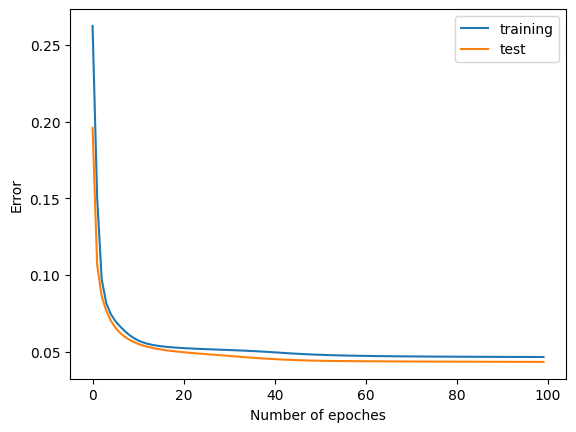

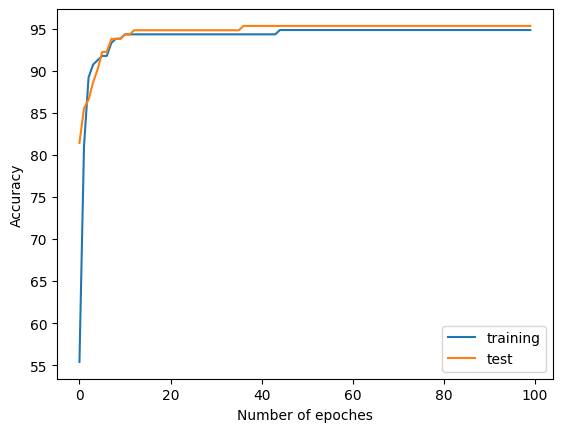

In [ ]:
random.seed(90)

# Network's architecture:
INPUT_SIZE = [22]
HIDDEN_LAYERS_SIZES = [5]
OUTPUT_SIZE = [1]

# Optimization parameters:
LEARNING_RATE = 0.7
amount_of_epochs = 100
batch_size = 1

nn1 = NeuralNetwork(INPUT_SIZE, HIDDEN_LAYERS_SIZES, OUTPUT_SIZE, LEARNING_RATE, amount_of_epochs, batch_size, data)
nn1.train()

epochs = []
for i in range(amount_of_epochs):
    epochs.append(i)
error_graph = pd.DataFrame(nn1.errors, epochs)
error_graph.plot(kind='line', ylabel='Error', xlabel='Number of epoches')
accuracy_graph = pd.DataFrame(nn1.accuracy, epochs)
accuracy_graph.plot(kind='line', ylabel='Accuracy', xlabel='Number of epoches')

print("The test accuracy is " + str(nn1.accuracy['test'][-1]) + "%")
print("The test error rate is " + str(nn1.errors['test'][-1]) + "%")

## Neural Network Errors Analysis

In [ ]:
# NeuralNetwork --> list
def find_incorrect_classifications(nn):
    incorrect_classifications = []
    for entry in nn.test_data:
        if nn.forward_pass_single_input(entry[0]) != entry[1][0]:
            incorrect_classifications.append(entry)
    for entry in nn.training_data:
        if nn.forward_pass_single_input(entry[0]) != entry[1][0]:
            incorrect_classifications.append(entry)
    return incorrect_classifications

incorrect_classifications = find_incorrect_classifications(nn1)
("There are " + str(len(incorrect_classifications)) + " incorrect classified entries in the dataset")

'There are 19 incorrect classified entries in the dataset'

In [ ]:
FN = 0
P = 0

for entry in incorrect_classifications:
  if entry[-1] == [1]:
    FN = FN + 1

for entry in nn1.test_data:
  if entry[-1] == [1]:
    P = P + 1
for entry in nn1.training_data:
  if entry[-1] == [1]:
    P = P + 1

TP = P - FN

print(TP/(TP+FN))

0.9205020920502092



Thank you for reviewing preprocessing_&_train_ckd_classification_model!

Created by [cayscays](https://github.com/cayscays/).